# Coronavirus (covid19) Tweets
## Tweets using hashtags associated with Coronavirus



This dataset contains the Tweets of users who have applied the following hashtags: 

**coronavirus, coronavirusoutbreak, coronavirusPandemic, covid19, covid_19, epitwitter, ihavecorona**


The goal of this analysis is to understand Twitter discourse around COVID-19

For that reason, we'll attemp to answer the following questions:

- Do more tweets about coronavirus indicate greater public awareness and seriousness and lead to a greater public acceptance of measures to limit spread, such as social distancing, and therefore fewer infections?

- Are some hashtags spreading more rapidly than others?

- Are tweeters prone to discussion (tweet replies) or sharing (quoted tweets)?

- Are people tweeting about particular symptoms?

and we'll do it with some basic Social Network Analysis (Part 1) and NLP (Part 2 and Part3)


Source: https://www.kaggle.com/smid80/coronavirus-covid19-tweets

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#! pip install node2vec
#! pip install tqdm 
#! pip install emoji

In [4]:
import warnings
warnings.filterwarnings('ignore')
import kaggle
from pathlib import Path
import os
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
from datetime import datetime, date
from collections import Counter
import re
from tqdm.auto import tqdm
import emoji
import string
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from node2vec import Node2Vec
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import chart_studio.plotly as py
#import plotly.offline as py
import plotly.graph_objects as go
#from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, plot
from plotly import tools
init_notebook_mode(connected=True)


#mpl.style.use('seaborn')
plt.style.use('ggplot')

In [5]:
import chart_studio

username = 'JULIANLB' # your username
api_key = '6YpPilA7QxwDoWt9Zcyl' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

## Download Covid-19-Tweets from Kaggle

In [6]:
path = Path('data')

### Load data

In [7]:
list_files = []

for dirname, _, filenames in os.walk(path):
    for filename in tqdm(filenames):
        if 'Coronavirus Tweets' in filename:
            df = pd.read_csv(os.path.join(dirname, filename), index_col=None, header=0)
            list_files.append(df)

df = pd.concat(list_files, axis=0, ignore_index=True)

In [8]:
df.shape

(26917655, 22)

In [9]:
df.head()

,status_id,user_id,created_at,screen_name,text,source,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,...,retweet_count,country_code,place_full_name,place_type,followers_count,friends_count,account_lang,account_created_at,verified,lang
0,1246588359528587267,1185238072075657216,2020-04-05T00:00:00Z,Cencalada1,@eldiarionorte Que el #COVID19 no se apodere d...,Twitter Web App,1.246349e+18,1.101089e+09,eldiarionorte,False,...,0,NaN,NaN,NaN,0,17,NaN,2019-10-18T16:56:13Z,False,es
1,1246588359688019970,18604464,2020-04-05T00:00:00Z,jhoysradt,Has anyone tried playing Nickleback at the vi...,Twitter for iPhone,NaN,NaN,NaN,False,...,0,US,"West Palm Beach, FL",city,1623,1543,NaN,2009-01-04T16:08:57Z,False,en
2,1246588360035991552,93706595,2020-04-05T00:00:00Z,longevitymag,Global superstar @Pink and her son Jameson are...,TweetDeck,NaN,NaN,NaN,False,...,0,NaN,NaN,NaN,6479,1593,NaN,2009-11-30T20:28:55Z,False,en
3,1246588360044363776,93206083,2020-04-05T00:00:00Z,SMM_sportradio,อัยยวัฒน์ ศรีวัฒนประภา เปิดใจผ่านจดหมายถึงแฟนบ...,TweetDeck,NaN,NaN,NaN,False,...,2,NaN,NaN,NaN,42206,352,NaN,2009-11-28T15:44:53Z,False,th
4,1246588360061095937,132225222,2020-04-05T00:00:00Z,SSalud_mx,#ConferenciaDePrensa sobre el #Coronavirus #CO...,TweetDeck,NaN,NaN,NaN,False,...,51,NaN,NaN,NaN,875211,216,NaN,2010-04-12T16:53:45Z,True,es


In [10]:
df.columns.tolist()

['status_id',
 'user_id',
 'created_at',
 'screen_name',
 'text',
 'source',
 'reply_to_status_id',
 'reply_to_user_id',
 'reply_to_screen_name',
 'is_quote',
 'is_retweet',
 'favourites_count',
 'retweet_count',
 'country_code',
 'place_full_name',
 'place_type',
 'followers_count',
 'friends_count',
 'account_lang',
 'account_created_at',
 'verified',
 'lang']

In [88]:
countries_df = pd.read_csv(path/'Countries.csv', index_col=None, header=0)
countries_df.head()

,country,country_code
0,NaN,NaN
1,Afghanistan,AF
2,Aland Islands,AX
3,Albania,AL
4,Algeria,DZ


# Exploration

In [11]:
df['is_retweet'].unique()

array([False])

In [12]:
df['hour'] = pd.to_datetime(df['created_at']).map(lambda x: x.hour)
df['day'] = pd.to_datetime(df['created_at']).map(lambda x: x.date)
df['is_reply'] = ~df['reply_to_user_id'].isna()

In [107]:
country_dict = dict(countries_df[['country_code', 'country']].values)

In [114]:
replies_by_country = df.groupby('country_code').is_reply.value_counts().unstack()
quotes_by_country = df.groupby('country_code').is_quote.value_counts().unstack()
tweets_by_country = pd.merge(replies_by_country, quotes_by_country, 
                             on='country_code', suffixes=('_replies', '_quotes'))
tweets_by_country['total'] = tweets_by_country['False_quotes'] + tweets_by_country['True_quotes']
tweets_by_country = tweets_by_country.sort_values(by='total', ascending=False).dropna().reset_index()[:50]
tweets_by_country['country'] = tweets_by_country['country_code'].map(lambda x: country_dict[x])
tweets_by_country.head()

,country_code,False_replies,True_replies,False_quotes,True_quotes,total,country
0,US,329000.0,53637.0,316558.0,66079.0,382637.0,United States
1,GB,99803.0,16281.0,97380.0,18704.0,116084.0,United Kingdom
2,IN,97498.0,17629.0,103457.0,11670.0,115127.0,India
3,ES,53500.0,8358.0,53767.0,8091.0,61858.0,Spain
4,CA,42641.0,6542.0,39105.0,10078.0,49183.0,Canada


In [124]:
top = tweets_by_country[:20]

fig = go.Figure()
fig.add_trace(go.Bar(x=top["country"], y=top["total"], name='Total'))
fig.add_trace(go.Bar(x=top["country"], y=top["True_quotes"], name='Quotes'))
fig.add_trace(go.Bar(x=top["country"], y=top["True_replies"], name='Replies'))
fig.update_layout(
    height=500, width = 900,
    barmode='group',
    title_text="Quotes and Reply tweets by Country",
)
fig.update_xaxes(tickangle=-45, tickfont=dict(family='Rockwell', size=9))
fig.show()
#py.plot(fig, filename = 'bars_repiles_quotes', auto_open=True)

In [121]:
tweets_by_country['true_replies_pct'] = tweets_by_country['True_replies']/tweets_by_country['total']
tweets_by_country['true_quotes_pct'] = tweets_by_country['True_quotes']/tweets_by_country['total']

In [127]:
fig = px.scatter(tweets_by_country, x='true_replies_pct', y='true_quotes_pct', text='country')
fig.update_traces(textposition='top center', textfont_size=8)
fig.update_layout(
    height=700, width=700,
    title_text='Replies vs Quotes scatterplot (% of Total)',
    xaxis = {'title': 'Replies (% of Total)', 'tickformat': ',.0%'},
    yaxis = {'title': 'Quotes (% of Total)', 'tickformat': ',.0%'}
)
fig.show()
py.plot(fig, filename = 'replies_vs_quotes', auto_open=True)

'https://plotly.com/~JULIANLB/52/'

In [132]:
top_countries = tweets_by_country['country_code'].unique()
countries_by_day = df[df['country_code'].isin(top_countries[:10])
                     ].groupby('day').country_code.value_counts().unstack(1).fillna(1)

In [133]:
countries_by_day = countries_by_day[-60:]
#countries_by_day = countries_by_day/countries_by_day.iloc[0]

In [134]:
days = countries_by_day.index.tolist()

In [135]:
list_countries = countries_by_day.columns.to_list()
colors = px.colors.qualitative.Plotly

fig = go.Figure()

c=0
for country_code in list_countries:

    fig.add_trace(
        go.Scatter(
            x = countries_by_day.index,
            y = countries_by_day[country_code],
            name = country_dict[country_code],
            mode='lines',
            marker=dict(color=colors[c],
                        size=1,
                        line=dict(color=colors[c], width=1))
        )
    )
    c += 1


### Create buttons for drop down menu
buttons = []

visibility = [True for i in range(len(list_countries))]
button = dict(
             label =  'All',
             method = 'update',
             args = [{'visible': visibility},
                 {'title': 'All'}])
buttons.append(button)

for i, label in enumerate(list_countries):
    visibility = [i==j for j in range(len(list_countries))]
    button = dict(
                 label =  country_dict[label],
                 method = 'update',
                 args = [{'visible': visibility},
                     {'title': country_dict[label]}])
    buttons.append(button)
    

updatemenus = list([
    dict(active=-1,
         x=0.65,
         y=1.2,
         buttons=buttons
    )
])

fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ))

fig['layout']['title'] = 'Amount of tweets by country'
fig['layout']['showlegend'] = False
fig['layout']['updatemenus'] = updatemenus
fig['layout']['yaxis'].update(title='', range=[0, 20000])
fig.update_xaxes(tickangle=-45, tickfont=dict(family='Rockwell', size=8))

iplot(fig, filename='dropdown')

#py.plot(fig, filename = 'img/tweets_by_country', auto_open=True)
py.plot(fig, filename = 'itweets_by_country', auto_open=True)

'https://plotly.com/~JULIANLB/5/'

In [138]:
def extract(start, tweet):
    words = tweet.split()
    return [word[1:] for word in words if word[0] == start]

def strip_punctuation(s):
    return s.translate(str.maketrans('','','!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))

def extract_hashtags(tweet):
    hashtags = [strip_punctuation(tag) for tag in extract('#', tweet)]
    result = []
    for tag in hashtags:
        if tag.lower() not in result:  
            result.append(tag.lower())
    return result

def get_flat_list(plain_list):
    
    flat_list = []
    plain_list = [x for x in plain_list if len(x)>0]
    
    for sublist in tqdm(plain_list):
        for item in sublist:
            flat_list.append(item)
            
    flat_list = [x for x in flat_list if x!='']
    
    return flat_list

In [139]:
#(!pip install swifter) swifter makes pandas apply faster using parallelization 
#(https://towardsdatascience.com/add-this-single-word-to-make-your-pandas-apply-faster-90ee2fffe9e8)

import swifter

df['hashtags'] = df['text'].swifter.apply(extract_hashtags)
df[['text', 'hashtags']].head()

,text,hashtags
0,@eldiarionorte Que el #COVID19 no se apodere d...,[covid19]
1,Has anyone tried playing Nickleback at the vi...,[covid19]
2,Global superstar @Pink and her son Jameson are...,"[pink, coronavirus, covid19]"
3,อัยยวัฒน์ ศรีวัฒนประภา เปิดใจผ่านจดหมายถึงแฟนบ...,"[smmsport, เลสเตอร์ซิตี้, leicestercity, โควิด..."
4,#ConferenciaDePrensa sobre el #Coronavirus #CO...,"[conferenciadeprensa, coronavirus, covid19, qu..."


In [142]:
list_hashtags = get_flat_list(df['hashtags'].tolist())

In [143]:
c = Counter(list_hashtags).most_common(30)
freq = [i[1] for i in c]
top_hashtags = [i[0] for i in c]

In [157]:
fig = px.bar(x=freq, y=top_hashtags, orientation='h')
fig.update_layout(
    height=700, width=800,
    title_text='Most Popular Hashtags',
    xaxis = {'title': 'Frequency'},
    yaxis = {'autorange': "reversed"}
)
fig.show()
py.plot(fig, filename = 'replies_vs_quotes', auto_open=True)

'https://plotly.com/~JULIANLB/52/'

In [98]:
def get_hashtag_network(df, hashtag: str):
    ''' returns a dataframe with the edges and timestamp from tweets feed (df)'''
    
    idx = (df.is_reply)  & (df.hashtags.swifter.apply(lambda x: hashtag in x))
    edges_df = df[idx][['user_id','reply_to_user_id', 'day']]
    
    edges_df = edges_df.dropna()
    edges_df = edges_df.drop_duplicates().reset_index(drop=True)
    edges_df = edges_df.rename(columns={'user_id': 'from', 'reply_to_user_id': 'to'})
    
    return edges_df


def get_strongly_gcc(G):
    """ get the giant strongly connected component of G""" 
    SGcc = max(nx.strongly_connected_components(G), key=len)
    SGcc = G.subgraph(SGcc)
    return SGcc

def get_weakly_gcc(G):
    """ get the giant weakly connected component of G"""  
    WGcc = max(nx.weakly_connected_components(G), key=len)
    WGcc = G.subgraph(WGcc)
    return WGcc
   

def plot_network(G, G_degree=None):
    ''' plot the graph with varying nodesize '''
    
    plt.figure(num=None, figsize=(15, 15), dpi=60, facecolor='w', edgecolor='k')
    pos = nx.spring_layout(G)
    
    if G_degree:
        node_size=[v * 10 for v in dict(G_degree).values()]
    else:
        node_size = 1
        
    nx.draw(G, pos, nodelist=dict(G_degree).keys(), node_size=node_size, width=0.5, alpha=0.5, edge_color='b')
    plt.axis('off')
    plt.show()

In [ ]:
edges_df = get_hashtag_network(df, 'socialdistancing')
G = nx.from_pandas_edgelist(edges_df, 'from', 'to', create_using=nx.DiGraph())
Gcc = get_weakly_gcc(G)
Gcc = Gcc.to_undirected()
Gcc_degree = Gcc.degree()

plot_network(Gcc, Gcc_degree)

# Social Network Analysis

### Example of a network: #quedateencasa

In [88]:
edges_df = get_hashtag_network(df, 'socialdistancing')

In [101]:
edges_df.head()

,from,to,day
0,45993399,976542720,2020-04-05
1,1964118115,827430126665211904,2020-04-05
2,966889213240070144,46917651,2020-04-05
3,1241209893740113922,1241209893740113920,2020-04-05
4,206500331,206500331,2020-04-05


In [90]:
G = nx.from_pandas_edgelist(edges_df, 'from', 'to', create_using=nx.DiGraph())

In [91]:
degrees = G.degree()

out_degrees = G.out_degree()
in_degrees = G.in_degree()

Text(0.5, 0, 'rank')

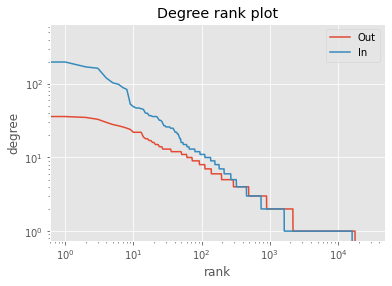

In [92]:
plt.loglog(sorted([n[1] for n in list(out_degrees)], reverse=True))
plt.loglog(sorted([n[1] for n in list(in_degrees)], reverse=True))
plt.title("Degree rank plot")
plt.legend(['Out', 'In'])
plt.ylabel("degree")
plt.xlabel("rank")

In [93]:
Gcc = get_weakly_gcc(G)
Gcc = Gcc.to_undirected()
Gcc_degree = Gcc.degree()

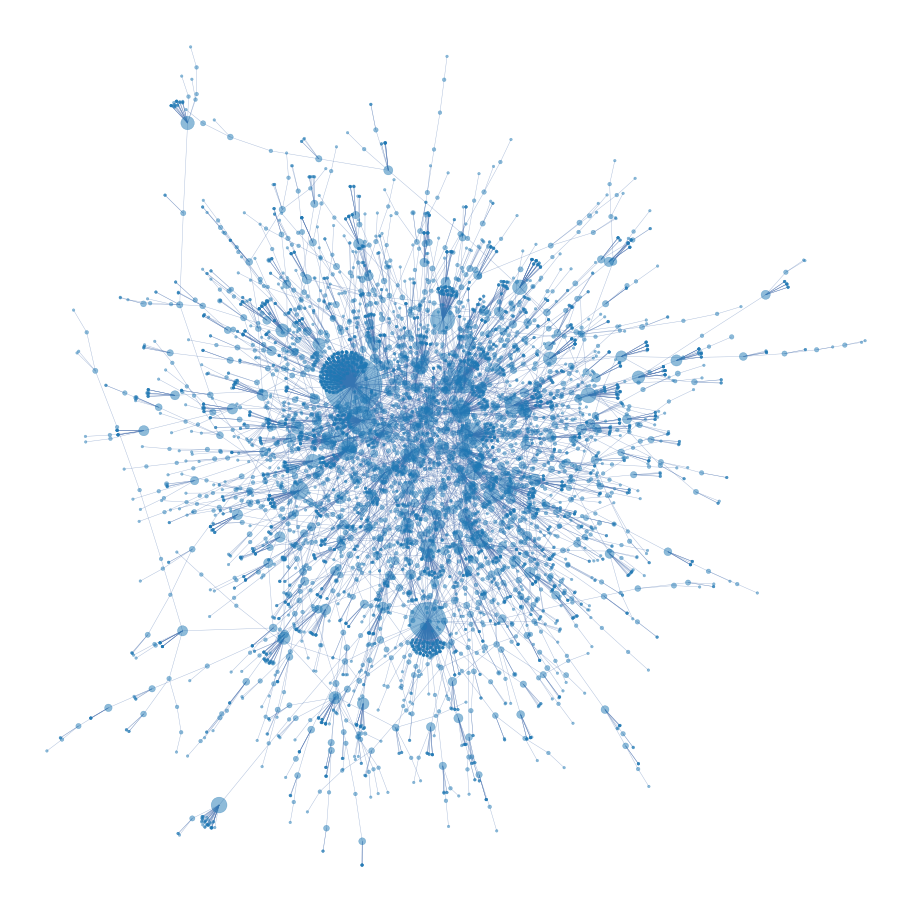

In [99]:
plot_network(Gcc, Gcc_degree)

### Measuring attributes evolution through time for multiple networks

In [155]:
def copmute_network_metrics(G):
    ''' Computes some metrics from graph G (networkx)'''
    G_cc = get_weakly_gcc(G).to_undirected()
    metrics = {}
    metrics['nodes'] = G.number_of_nodes()
    metrics['edges'] = G.number_of_edges()
    metrics['degrees'] = G.degree()
    metrics['avg degrees'] = np.mean([n[1] for n in list(de)])
    metrics['diameter'] = nx.diameter(G_cc)                                
    try:
        metrics['assortativity'] = nx.degree_pearson_correlation_coefficient(G_cc)
    except:
        metrics['assortativity'] = None

    return metrics

def get_daily_metrics(df, hashtag_list):
    
    info = dict()
    for hashtag in tqdm(hashtag_list):

        edges_df = get_hashtag_network(df, hashtag)
        days = edges_df.sort_values(by='day')['day'].unique().tolist()
        hashtag_metrics = {}
        # initiate an empty graph
        G_day = nx.DiGraph()

        for i in tqdm(range(len(days))):
            day_info = {}
            edges = [tuple(x) for x in edges_df[edges_df.day == days[i]][['from', 'to']].drop_duplicates().to_numpy()]
            G_day.update(edges=edges) # updates graphs adding new edges
            day_metrics = copmute_network_metrics(G_day)
            hashtag_metrics[days[i]] = day_metrics

        print('Hashtag: {}, Day : {}, Nodes: {}, Edges: {}'.format(hashtag,
                                                                   days[i],
                                                                   day_info['nodes'],
                                                                   day_info['edges']))

        info[hashtag] = hashtag_metrics    
    
    return info

hashtag_list = ['stayathome', 'lockdown', 'socialdistancing',  'flattenthecurve', 'masks4all', 'trump']
info = get_daily_metrics(df, hashtag_list)

trump



edges_df: done



Hashtag: trump, Day : 2020-04-30, Nodes: 22082, Edges: 27858



In [156]:
hashtag_list = list(info.keys())
hashtag_list

['stayathome',
 'lockdown',
 'socialdistancing',
 'flattenthecurve',
 'masks4all',
 'trump']

We add a new attribute:

- average number of edges created by a nodes that were added on a given day: 

$$\frac{|E(G_{t})|-|E(G_{t-1})|}{|V(G_{t})|-|V(G_{t-1})|}$$

In [157]:
info_df_list = [pd.DataFrame(info[hashtag]).T for hashtag in hashtag_list]

for i in range(len(hashtag_list)):
    info_df_list[i]['hashtag'] = hashtag_list[i]
    info_df_list[i]['edges_created'] = (info_df_list[i]['edges']-
                                        info_df_list[i]['edges'].shift(1))/(info_df_list[i]['nodes']-
                                                                            info_df_list[i]['nodes'].shift(1))
hashtags_df = pd.DataFrame()
for i in range(len(info_pd_list)):
    hashtags_df = hashtags_df.append(info_pd_list[i])

In [434]:
fig = make_subplots(rows=2, cols=3, shared_yaxes=False, shared_xaxes=True,
                   subplot_titles=('Nodes', 'Edges Created',  'Diameter', 'Avg Degrees', 'Edges', 'Assortativity'))


list_metrics = ['nodes', 'edges_created',  'diameter', 'avg degrees', 'edges', 'assortativity']
colors = px.colors.qualitative.Plotly

i, j = 1,1

for metric in list_metrics:
    
    trace = dict()
    
    show_legend = False
    
    c=0
    
    for hashtag in hashtag_list:
        
        
        x = hashtags_df[hashtags_df['hashtag']==hashtag]
        
        trace[hashtag] = go.Scatter(x=x.index, y=x[metric], name=hashtag, mode='lines',
                                    marker=dict(color=colors[c],
                                                size=1,
                                                line=dict(color=colors[c], width=1)),
                                    showlegend=show_legend
                                    )
        
        show_legend = False
        c += 1
        fig.append_trace(trace[hashtag], row=i, col=j)
    
    
    if j < 3:
        j += 1
    else:
        j = 1
        i += 1
    

### Create buttons for drop down menu
buttons = []

visibility = [True for i in range(len(hashtag_list))]
button = dict(
             label =  'All',
             method = 'update',
             args = [{'visible': visibility},
                 {'title': 'All'}])
buttons.append(button)

for i, label in enumerate(hashtag_list):
    visibility = [i==j for j in range(len(hashtag_list))]
    button = dict(
                 label =  label,
                 method = 'update',
                 args = [{'visible': visibility},
                     {'title': '#'+label}])
    buttons.append(button)
    

updatemenus = list([
    dict(active=-1,
         x=0.45,
         y=1.25,
         buttons=buttons
    )
])

fig['layout']['title'] = 'Hashtags Networks Metrics'
fig['layout']['showlegend'] = False
fig['layout']['updatemenus'] = updatemenus
fig['layout']['yaxis1'].update(range=[-1000, 37000])
fig['layout']['yaxis2'].update(range=[0.45, 1.8])
fig['layout']['yaxis3'].update(range=[-1, 35])
fig['layout']['yaxis4'].update(range=[0.95, 2.6])
fig['layout']['yaxis5'].update(range=[-1000, 31000])
fig['layout']['yaxis6'].update(range=[-1.02, 0])

fig.update_xaxes(tickangle=-45, tickfont=dict(family='Rockwell', size=8))

iplot(fig, filename='dropdown')

py.plot(fig, filename = 'img/metrics', auto_open=True)


'img/metrics.html'

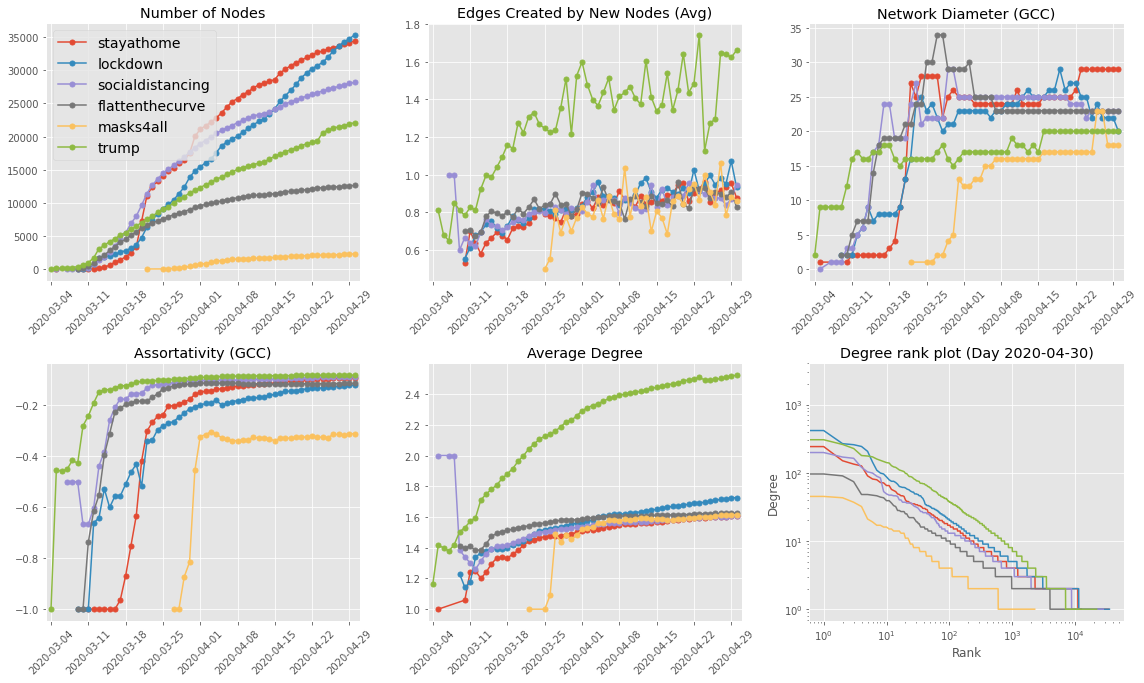

In [172]:
num_colors = len(hashtag_list)
#cm = plt.get_cmap('Accent')

fig, axs = plt.subplots(2,3, figsize=(16, 9.6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

params={'markersize':10, 'style':'.-', 'rot':45}

for i in range(len(hashtag_list)):

    params['label'] = hashtag_list[i]
    #params['c'] = cm(1.*i/num_colors)
    info_pd_list[i]['nodes'].plot(ax=axs[0], **params, title='Number of Nodes')
    info_pd_list[i]['edges_created'].plot(ax=axs[1],  **params, title='Edges Created by New Nodes (Avg)')
    info_pd_list[i]['diameter'].plot(ax=axs[2], **params, title='Network Diameter (GCC)')
    info_pd_list[i]['assortativity'].plot(ax=axs[3], **params, title='Assortativity (GCC)')
    info_pd_list[i]['avg degrees'].plot(ax=axs[4], **params, title='Average Degree')
    #info_pd_list[i]['edges'].plot(ax=axs[4], **params, title='Number of Edges')
    
    axs[5].loglog(sorted([n[1] for n in list(info_pd_list[i]['degrees'][-1])], reverse=True))

axs[0].legend(prop={'size': 14})
axs[5].set_title('Degree rank plot (Day {})'.format(info_pd_list[0].index[-1]))
axs[5].set_ylabel("Degree")
axs[5].set_xlabel("Rank")

for i in range(5):
    axs[i].set_xlim(date(2020, 3, 3), date(2020, 5, 1))
    axs[i].set_xticks(days[0::7])
fig.tight_layout()

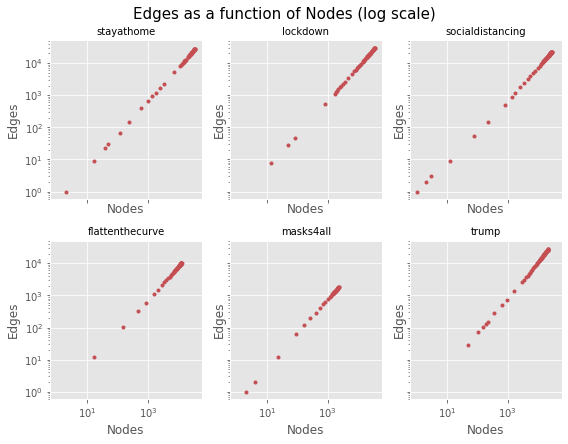

In [161]:
fig, axs = plt.subplots(2,3, figsize=(8, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(len(hashtag_list)):

    axs[i].plot(info_pd_list[i]['nodes'], info_pd_list[i]['edges'], '.', c='r')
    axs[i].set_title('{}'.format(hashtag_list[i]), fontsize=10)
    axs[i].set_ylabel('Edges')
    axs[i].set_xlabel('Nodes')
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')

fig.suptitle('Edges as a function of Nodes (log scale)', fontsize=15, y=1.02)
fig.tight_layout()
plt.show()

In [166]:
import csv   
for i in range(len(hashtag_list)):
    info_pd_list[i].to_csv('info_graphs_2.csv', mode='a', header=False)

In [154]:
#pd.read_csv('info_graphs.csv', hFalse)